In [1]:
import torch
from network import components as lay
from network import functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
import numpy as np
from IPython.display import clear_output
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

# Load Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    #transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [4]:
def load_data():
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    trainloader = DataLoader(mnist_trainset, batch_size=10, shuffle=False)
    test_loader = DataLoader(mnist_testset, batch_size=10, shuffle=False)
    return trainloader, test_loader

In [5]:
train, test = load_data()

# Model

In [12]:
class Convolution(object):
    def __init__(self, input_size, kernel_size : tuple = (2,2), stride : int = 1, padding : tuple = (0,0), channels : int = 1):
        super(Convolution, self).__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.channels = channels
        self.intial = True
        
        self.size_x = math.floor(((input_size[1] - kernel_size[1] + padding[1] * 2)/stride) + 1)
        self.size_y = math.floor(((input_size[0] - kernel_size[0] + padding[0] * 2)/stride) + 1)
        
        self.kernels = torch.rand((channels, kernel_size[0], kernel_size[1]), dtype=torch.float)
        self.bias = torch.rand((channels, self.size_y, self.size_x), dtype=torch.float)
        
        self.output_feature = torch.zeros((channels, self.size_y, self.size_x),dtype=torch.float)
        
        return
    
    def forward(self, input_matrix): 
        
        #normalise
        _mean = torch.mean(input_matrix, dim = (1,2))
        _std = torch.std(input_matrix, dim = (1,2))
        for i in range(input_matrix.shape[0]):
            input_matrix[i] = (input_matrix[i] - _mean[i])/ _std[i]
        
        #match channels
        if (input_matrix.shape[0] > 1) and self.intial:
            self.channels = input_matrix.shape[0]
            self.kernels = torch.rand((self.channels, self.kernel_size[0], self.kernel_size[1]), dtype=torch.float)
            self.bias = torch.rand((self.channels, self.size_y, self.size_x), dtype=torch.float)
            self.intial = False
            
        #pad x
        if self.padding[0] > 0:
            pad_tensor = torch.zeros((input_matrix.shape[0], input_matrix.shape[1] + self.padding[0] * 2, input_matrix.shape[2]), dtype=torch.float)
            pad_tensor[:, self.padding[0]: - self.padding[0], :] = input_matrix[:, :, :]
            input_matrix = pad_tensor
        
        #pad y
        if self.padding[1] > 0:
            pad_tensor = torch.zeros((input_matrix.shape[0], input_matrix.shape[1], input_matrix.shape[2] + self.padding[1] * 2), dtype=torch.float)
            pad_tensor[:, :, self.padding[1]: - self.padding[1]] = input_matrix[:, :, :]
            input_matrix = pad_tensor
        
        self.input = input_matrix
        self.output_feature = torch.zeros((self.channels, self.size_y, self.size_x),dtype=torch.float)
        col = 0
        for j in range(self.size_y):
            row = 0
            for i in range(self.size_x):
                
                window = input_matrix[:, col:col+self.kernel_size[0], row:row+self.kernel_size[1]]
                _sum = torch.sum(window * self.kernels[:,], dim = (1,2))
                self.output_feature[:, j, i] = _sum + self.bias[:, j, i]
                
                row += self.stride
                        
            col += self.stride

        return self.output_feature
    
    def back(self, gradient, lr:float=0.01):
        
        self.delta_k = torch.zeros((self.channels, self.kernel_size[0], self.kernel_size[1]),dtype=torch.float)
        col = 0
        for j in range(self.kernel_size[0]):
            row = 0
            for i in range(self.kernel_size[1]):
                
                window = self.input[:, col:col+gradient.shape[1], row:row+gradient.shape[2]]
                self.delta_k[:, j, i] = torch.sum(window * gradient[:,], dim = (1,2))
                
                row += self.stride
                        
            col += self.stride
        
        #print("GRAD::::", gradient.shape)
        #print("WEIGHTS:", self.kernels.shape)
        #print("DELTA W:", self.delta_k.shape)
        
        self.kernels = self.kernels - self.delta_k * lr
        self.bias = self.bias - gradient * lr

        
        rot_kernal = torch.rot90(self.kernels, 1, [1, 2])
        rot_kernal = torch.rot90(rot_kernal, 1, [1, 2])
        #rot_kernal = torch.rot90(rot_kernal, 1, [1, 2])
        
        self.delta_x = torch.zeros((self.channels, self.input_size[0],self.input_size[1]),dtype=torch.float)
        
        padding = (self.input.shape[1] - self.kernels.shape[1], self.input.shape[2] - self.kernels.shape[2])
        
        pad_tensor = torch.zeros((rot_kernal.shape[0], rot_kernal.shape[1] + padding[0] * 2, rot_kernal.shape[2] + padding[1] * 2), dtype=torch.float)
        pad_tensor[:, padding[0]: -padding[0], padding[1]: - padding[1]] = rot_kernal[:, :, :]
        rot_kernal = pad_tensor
        
        #print("ROT:", rot_kernal.shape)
        col = 0
        for j in range(self.input_size[0]):
            row = 0
            for i in range(self.input_size[1]):
                
                window = rot_kernal[:, col:col+gradient.shape[1], row:row+gradient.shape[2]]
                #print("WINDW:", window.shape)
                self.delta_x[:, j, i] = torch.sum(window * gradient[:,], dim = (1,2))
                
                row += self.stride
                        
            col += self.stride
            
        #print("INPUTS :", self.input.shape)
        #print("DELTA X:", self.delta_x.shape)

        return self.delta_x

In [13]:
class Pooling(object):
    def __init__(self, input_size, window_size : tuple = (2,2), stride : int = 1, _type = 'AVG'):
        super(Pooling, self).__init__()
        
        self.input_size = input_size
        self.window_size = window_size
        self.stride = stride
        self._type = _type
        
        return
    
    def forward(self, input_matrix): 
        
        size_x = math.floor(((self.input_size[1] - self.window_size[1])/self.stride) + 1)
        size_y = math.floor(((self.input_size[0] - self.window_size[0])/self.stride) + 1)
        
        output_feature = torch.zeros((input_matrix.shape[0], size_y, size_x),dtype=torch.float)
        
        col = 0
        for j in range(size_y):
            row = 0
            for i in range(size_x):
                
                window = input_matrix[:, col:col+self.window_size[0], row:row+self.window_size[1]]
                win_grad = torch.zeros_like(window)
                if self._type == 'AVG':
                    output_feature[:, j, i] = torch.mean(window, dim = (1,2))
                else:
                    output_feature[:, j, i] = torch.amax(window,dim=(1,2))
                    
                    if torch.count_nonzero(window) != 0:
                         
                        
                        pass

                row += self.stride

            col += self.stride
        
        return output_feature
    
    def back(self, gradient):
        if self._type == 'AVG':
            grad = 1
        else:
            grad = 1
        return grad

In [30]:
class TestModel_old(object):
    def __init__(self, input_size, output_size):
        super(TestModel_old, self).__init__()
        
        self.conv1 = Convolution(input_size, kernel_size=(3,3), channels = 3, padding = (1,1))
        #((height + pad*2 - kernel_height)/stride) + 1
        self.relu1 = lay.ReLu()
        #self.pool1 = Pooling((28,28), window_size=(3,3), _type='MAX')
        self.conv2 = Convolution((28,28), kernel_size=(5,5))
        self.relu2 = lay.ReLu()
        self.fc1 = lay.FullyConnected(576 * 3,100)
        self.relu3 = lay.Sigmoid()
        self.fc2 = lay.FullyConnected(100,10)
        self.softmax = lay.Softmax()
        
        return
    
    def forward(self, inp):
        
        out = self.conv1.forward(inp)
        out = self.relu1.forward(out)
        #out = self.pool1.forward(out)
        out = self.conv2.forward(out)
        out = self.relu2.forward(out)
        out = F.stack(out)
        out = self.fc1.forward(out)
        out = self.relu3.forward(out)
        out = self.fc2.forward(out)
        out = self.softmax.forward(out)
        
        return out#
    
    def forward_show(self, inp):
        
        out = self.conv1.forward(inp)
        print("CONV1:", out.shape)
        plt.imshow(out[0],cmap='gray')
        plt.show()
        plt.imshow(out[1],cmap='gray')
        plt.show()
        plt.imshow(out[2],cmap='gray')
        plt.show()
        #plt.imshow(out[3],cmap='gray')
        #plt.show()
        #plt.imshow(out[4],cmap='gray')
        #plt.show()
        
        out = self.relu1.forward(out)
        print("RELU1:", out.shape)
        plt.imshow(out[0],cmap='gray')
        plt.show()
        plt.imshow(out[1],cmap='gray')
        plt.show()
        plt.imshow(out[2],cmap='gray')
        plt.show()
        #plt.imshow(out[3],cmap='gray')
        #plt.show()
        #plt.imshow(out[4],cmap='gray')
        #plt.show()
        
        #out = self.pool1.forward(out)
        #print("POOL1:", out.shape)
        #plt.imshow(out[0],cmap='gray')
        #plt.show()
        #plt.imshow(out[1],cmap='gray')
        #plt.show()
        #plt.imshow(out[2],cmap='gray')
        #plt.show()
        #plt.imshow(out[3],cmap='gray')
        #plt.show()
        #plt.imshow(out[4],cmap='gray')
        #plt.show()
        
        out = self.conv2.forward(out)
        print("CONV2:", out.shape)
        plt.imshow(out[0],cmap='gray')
        plt.show()
        plt.imshow(out[1],cmap='gray')
        plt.show()
        plt.imshow(out[2],cmap='gray')
        plt.show()
        #plt.imshow(out[3],cmap='gray')
        #plt.show()
        #plt.imshow(out[4],cmap='gray')
        #plt.show()
        
        out = self.relu2.forward(out)
        print("RELU2:", out.shape)
        plt.imshow(out[0],cmap='gray')
        plt.show()
        plt.imshow(out[1],cmap='gray')
        plt.show()
        plt.imshow(out[2],cmap='gray')
        plt.show()
        #plt.imshow(out[3],cmap='gray')
        #plt.show()
        #plt.imshow(out[4],cmap='gray')
        #plt.show()
        
        out = F.stack(out)
        print(out)
        out = self.fc1.forward(out)
        out = self.relu3.forward(out)
        out = self.fc2.forward(out)
        out = self.softmax.forward(out)
        
        return out
    
    def backward(self, loss_grad, lr : float=0.01):
        
        gradient = loss_grad
        gradient = self.softmax.back(gradient)
        gradient = self.fc2.back(gradient, lr=lr)
        gradient = self.relu3.back(gradient)
        gradient = self.fc1.back(gradient, lr=lr)
        #print(gradient)
        gradient = gradient.view(3, 24, 24)
        #print(gradient)
        gradient = self.relu2.back(gradient)
        gradient = self.conv2.back(gradient,lr=lr)
        #gradient = self.pool1.back(gradient)
        gradient = self.relu1.back(gradient)
        gradient = self.conv1.back(gradient,lr=lr)
        
    
        return

In [31]:
class TestModel(object):
    def __init__(self, input_size, output_size):
        super(TestModel, self).__init__()
        
        self.conv1 = Convolution(input_size, kernel_size=(3,3), channels = 3, padding = (1,1))
        #((height + pad*2 - kernel_height)/stride) + 1
        self.sigmoid1 = lay.Sigmoid()
        self.fc1 = lay.FullyConnected(784 * 3,100)
        self.sigmoid2 = lay.Sigmoid()
        self.fc2 = lay.FullyConnected(100,10)
        self.sigmoid3 = lay.Sigmoid()
        
        return
    
    def forward(self, inp):
        
        out = self.conv1.forward(inp)
        out = self.sigmoid1.forward(out)
        out = F.stack(out)
        out = self.fc1.forward(out)
        out = self.sigmoid2.forward(out)
        out = self.fc2.forward(out)
        out = self.sigmoid3.forward(out)
        
        return out#
    
    def forward_show(self, inp):
        
        out = self.conv1.forward(inp)
        print("CONV1:", out.shape)
        plt.imshow(out[0],cmap='gray')
        plt.show()
        plt.imshow(out[1],cmap='gray')
        plt.show()
        plt.imshow(out[2],cmap='gray')
        plt.show()
        #plt.imshow(out[3],cmap='gray')
        #plt.show()
        #plt.imshow(out[4],cmap='gray')
        #plt.show()
        
        out = self.sigmoid1.forward(out)
        print("SIGM1:", out.shape)
        plt.imshow(out[0],cmap='gray')
        plt.show()
        plt.imshow(out[1],cmap='gray')
        plt.show()
        plt.imshow(out[2],cmap='gray')
        plt.show()
        #plt.imshow(out[3],cmap='gray')
        #plt.show()
        #plt.imshow(out[4],cmap='gray')
        #plt.show()
        
        out = F.stack(out)
        print(out)
        out = self.fc1.forward(out)
        out = self.sigmoid2.forward(out)
        out = self.fc2.forward(out)
        out = self.sigmoid3.forward(out)
        
        return out
    
    def backward(self, loss_grad, lr : float=0.01):
        
        gradient = loss_grad
        gradient = self.sigmoid3.back(gradient)
        gradient = self.fc2.back(gradient, lr=lr)
        gradient = self.sigmoid2.back(gradient)
        gradient = self.fc1.back(gradient, lr=lr)
        gradient = gradient.view(3, 28, 28)
        gradient = self.sigmoid1.back(gradient)
        gradient = self.conv1.back(gradient,lr=lr)
    
        return

In [32]:
model = TestModel_old((28,28), 10)
loss_function = F.MSELoss()

# Train

  0%|          | 0/20 [00:00<?, ?it/s]

LOSS: tensor(0.7145)
LOSS: tensor(0.6564)
LOSS: tensor(0.5631)
LOSS: tensor(0.5504)
LOSS: tensor(0.5442)
LOSS: tensor(0.5049)
LOSS: tensor(0.4926)
LOSS: tensor(0.4823)
LOSS: tensor(0.5049)
LOSS: tensor(0.5333)
LOSS: tensor(0.5912)
LOSS: tensor(0.5845)
LOSS: tensor(0.5483)
LOSS: tensor(0.4558)
LOSS: tensor(0.4558)
LOSS: tensor(0.4212)
LOSS: tensor(0.4327)
LOSS: tensor(0.4848)
LOSS: tensor(0.3877)
LOSS: tensor(0.3776)
CONV1: torch.Size([3, 28, 28])


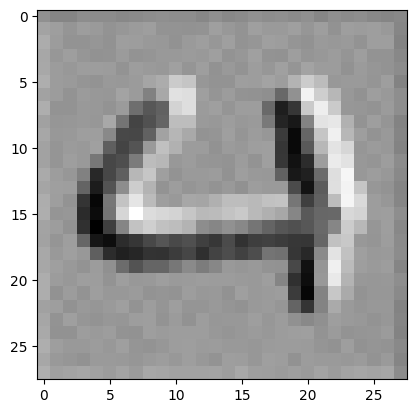

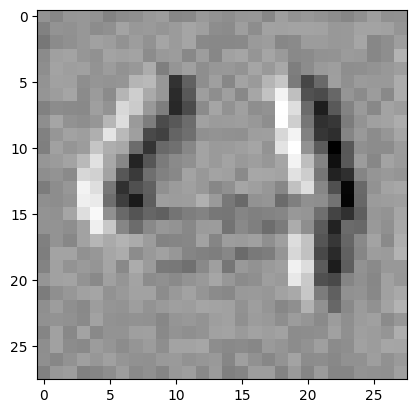

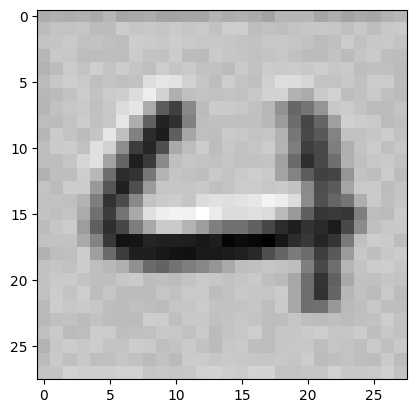

RELU1: torch.Size([3, 28, 28])


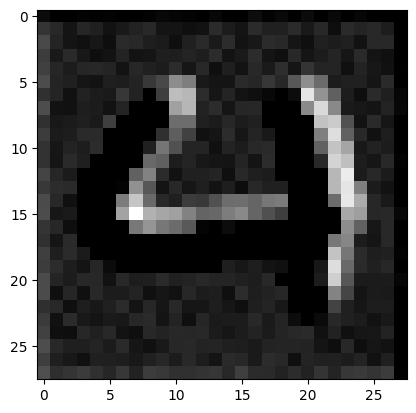

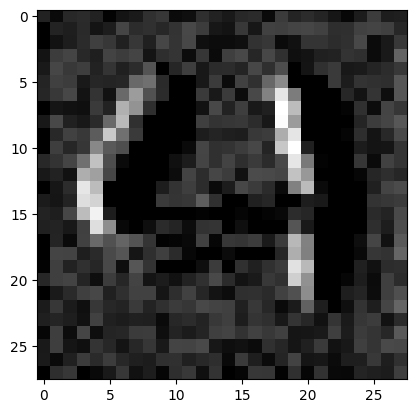

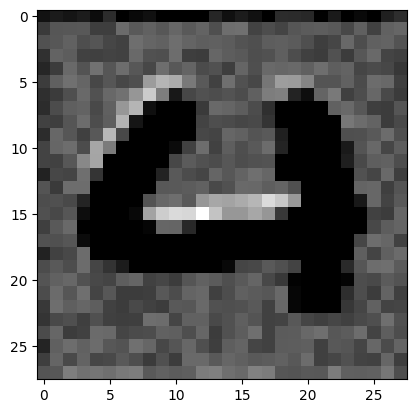

CONV2: torch.Size([3, 24, 24])


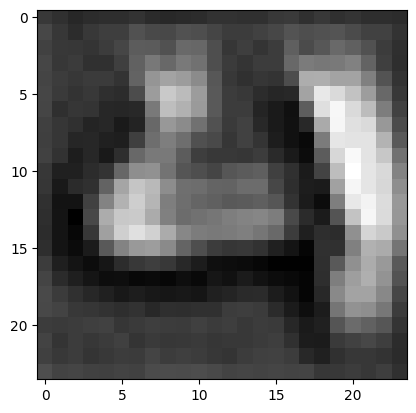

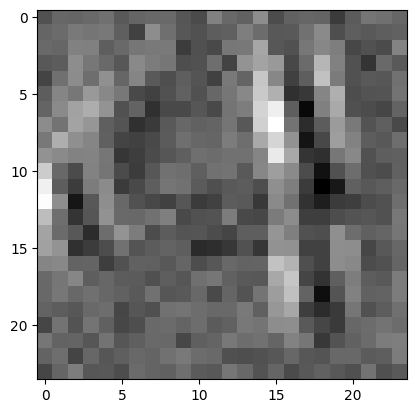

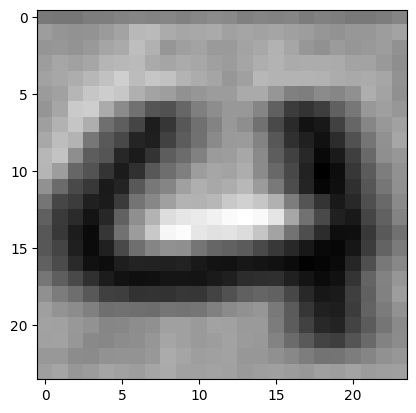

RELU2: torch.Size([3, 24, 24])


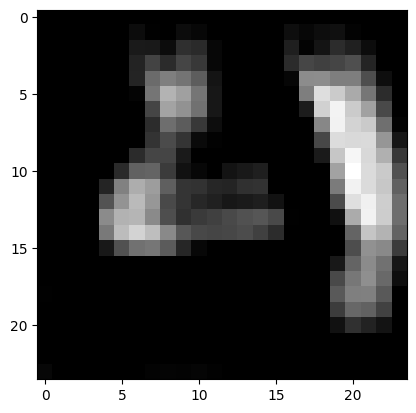

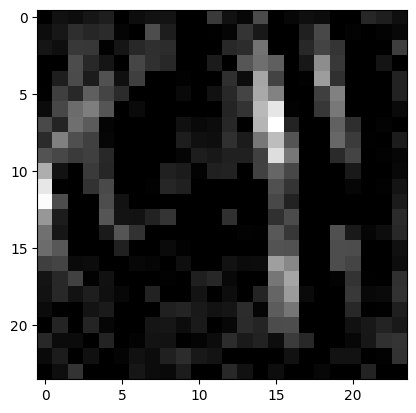

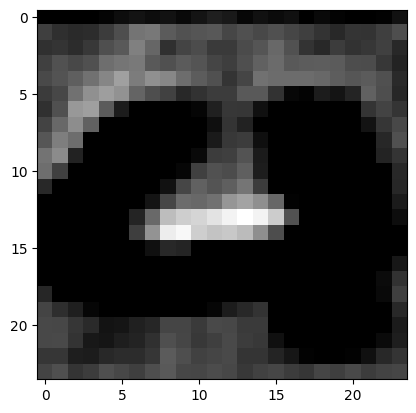

tensor([0.0000, 0.0000, 0.0000,  ..., 5.7296, 6.3251, 6.5648])


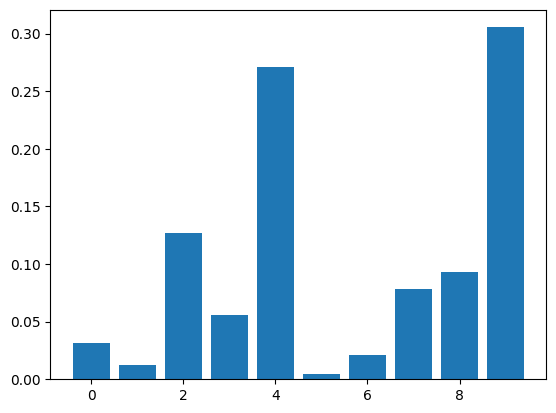

LABEL: tensor(4)


In [33]:
from tqdm import tqdm
num = 5
SHOW = True
examples = 10
for epoch in tqdm(range(20)):
    batch_count = 0
    AVGloss = 0
    for train_batch in train:
        batch_size = np.shape(train_batch[1])[0]
        #AVGloss = 0
                
        if batch_count > num:
            break
        batch_count += 1
        
        ex_count = 0 
        for i in range(batch_size):
            if ex_count > examples:
                break
            ex_count += 1
                    
            _input = train_batch[0][i]
            _label = torch.zeros(10, dtype=torch.float)
            _label[train_batch[1][i]] = 1.0

            result = model.forward(_input)
            _loss =  loss_function.calculate(result, _label)
            model.backward(loss_function.back(), lr=0.2)
            AVGloss += torch.sum(_loss) / batch_size
            
    print("LOSS:", AVGloss/num)
            
if SHOW:
    result = model.forward_show(train_batch[0][0])
    plt.bar([0,1,2,3,4,5,6,7,8,9], result)
    plt.show()
    print("LABEL:", train_batch[1][0])

CONV1: torch.Size([3, 28, 28])


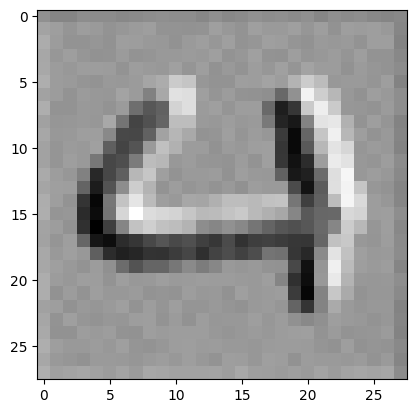

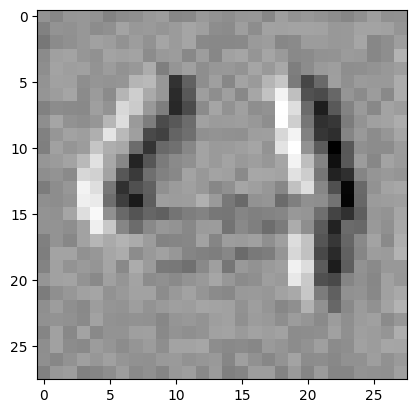

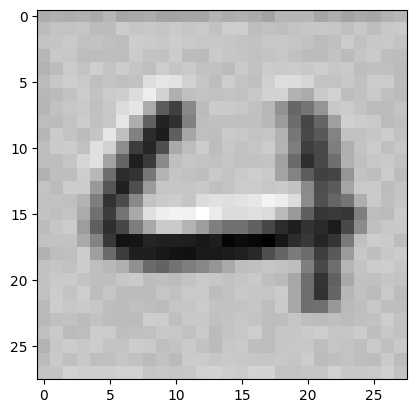

RELU1: torch.Size([3, 28, 28])


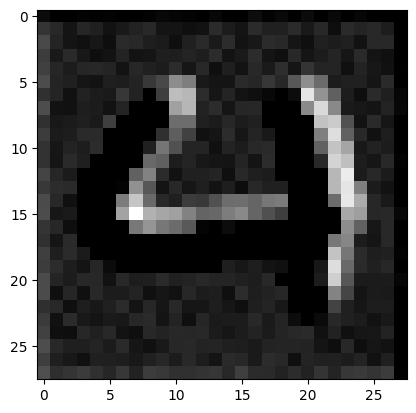

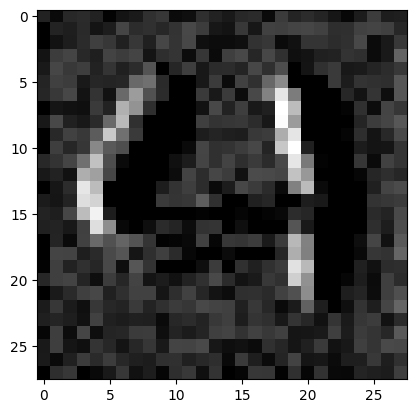

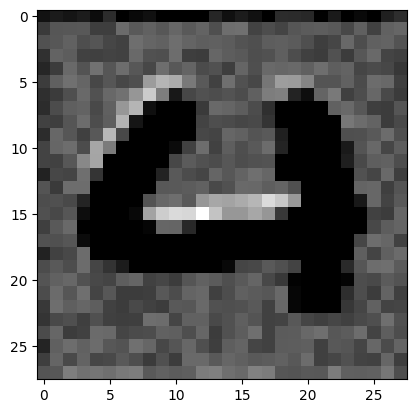

CONV2: torch.Size([3, 24, 24])


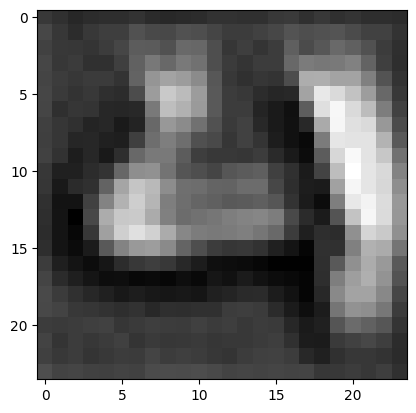

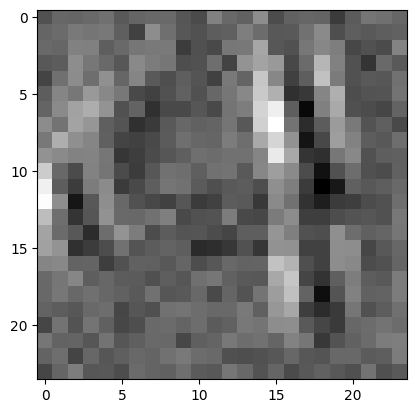

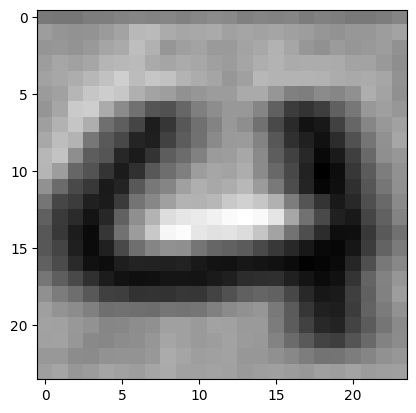

RELU2: torch.Size([3, 24, 24])


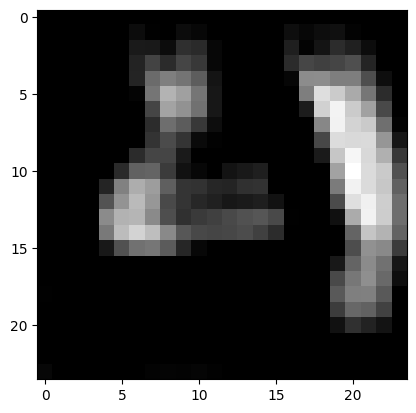

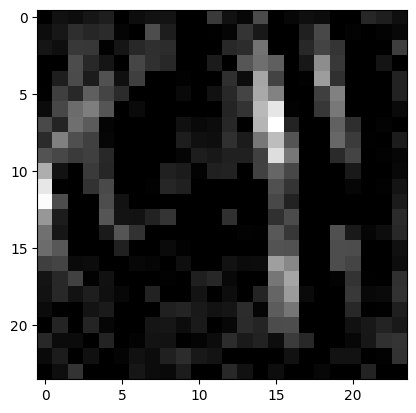

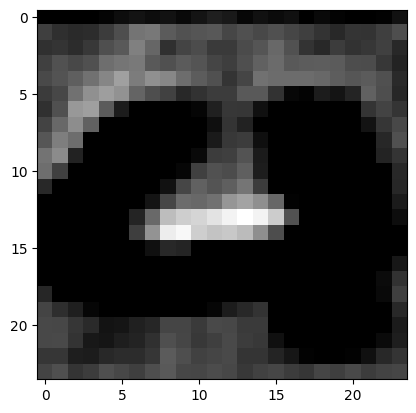

tensor([0.0000, 0.0000, 0.0000,  ..., 5.7296, 6.3251, 6.5648])


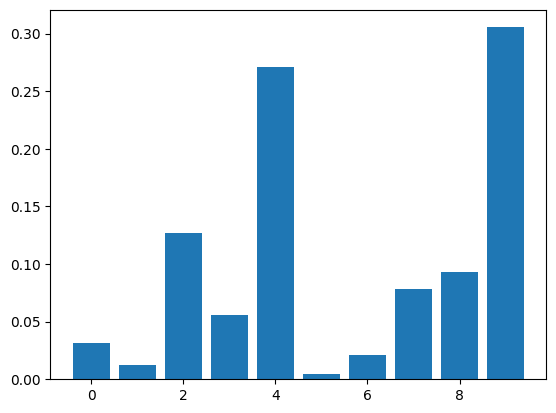

LABEL: tensor(4)
CONV1: torch.Size([3, 28, 28])


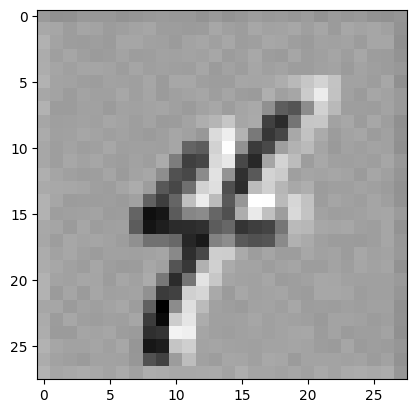

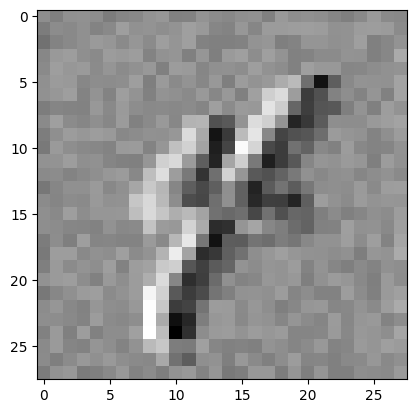

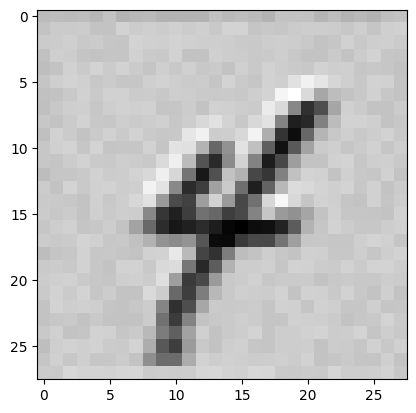

RELU1: torch.Size([3, 28, 28])


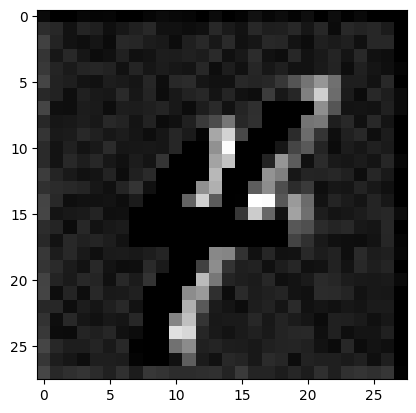

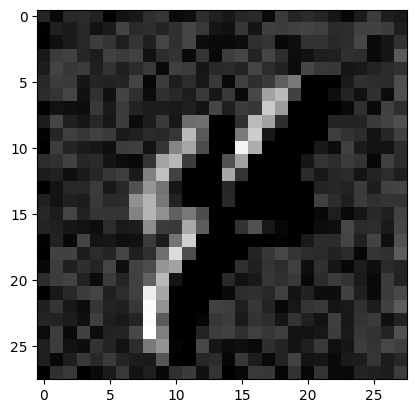

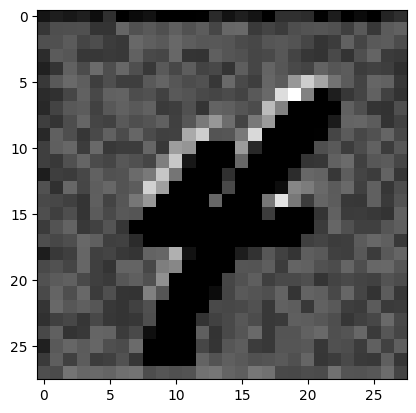

CONV2: torch.Size([3, 24, 24])


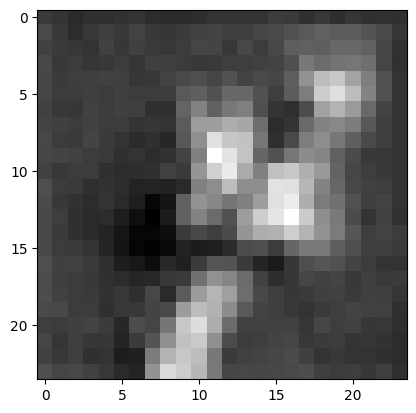

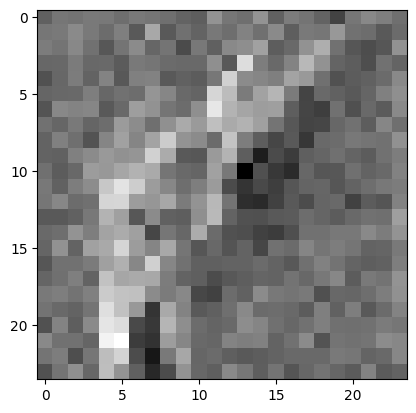

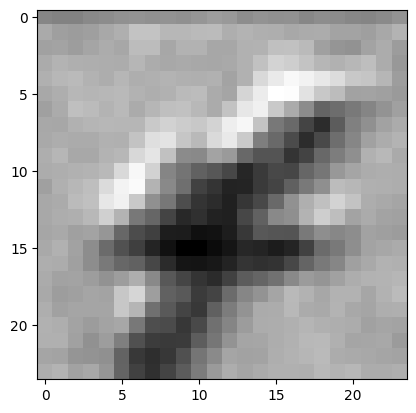

RELU2: torch.Size([3, 24, 24])


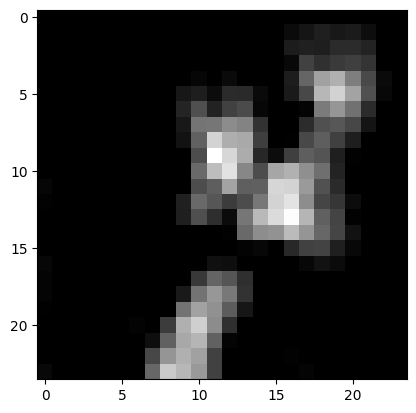

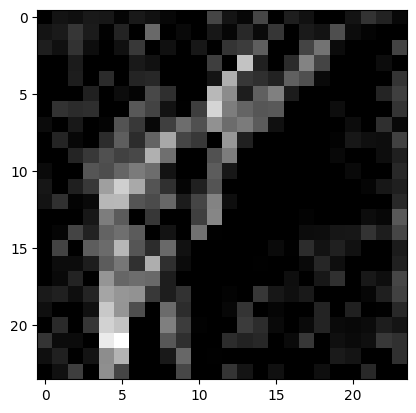

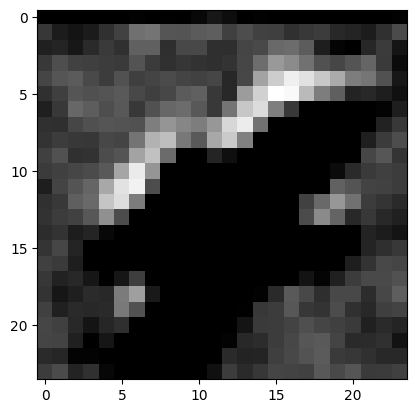

tensor([0.0000, 0.0000, 0.0000,  ..., 4.3764, 4.4301, 4.8359])


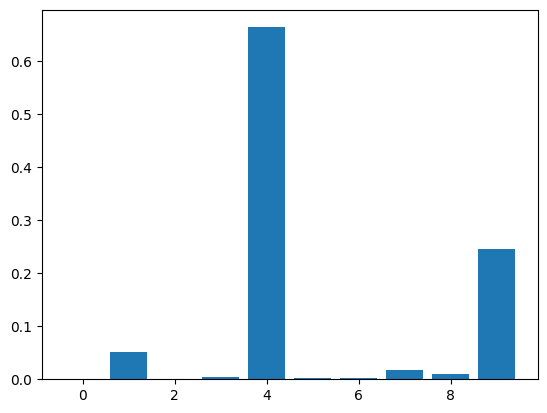

LABEL: tensor(4)
CONV1: torch.Size([3, 28, 28])


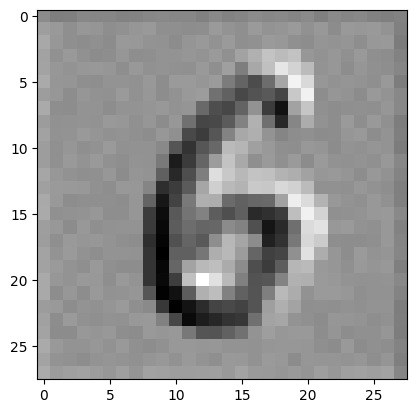

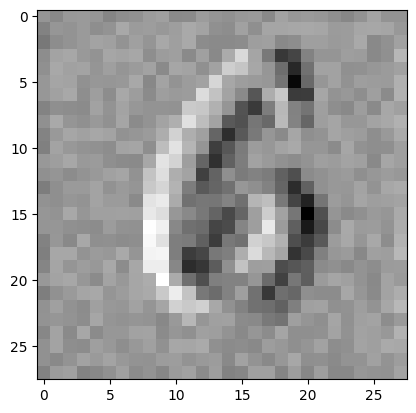

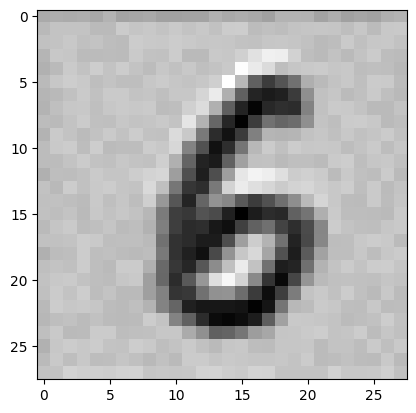

RELU1: torch.Size([3, 28, 28])


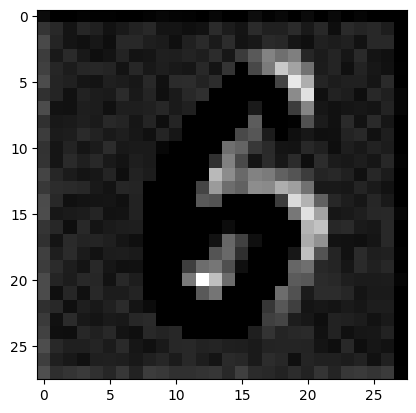

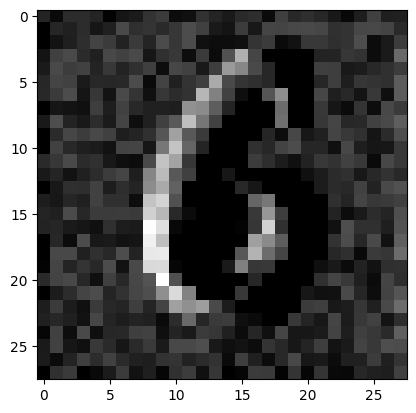

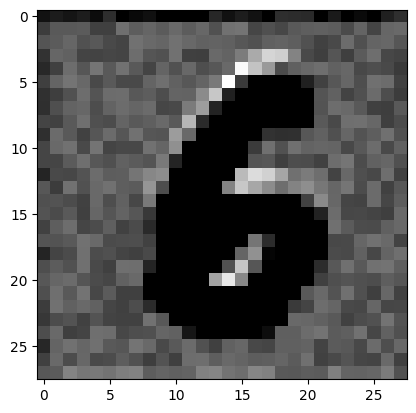

CONV2: torch.Size([3, 24, 24])


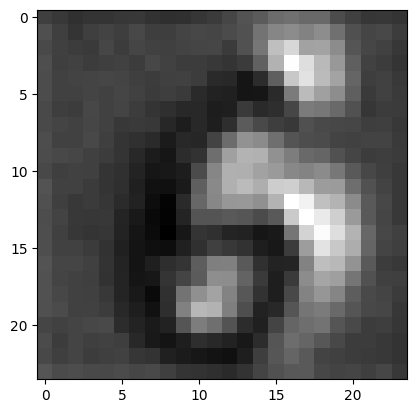

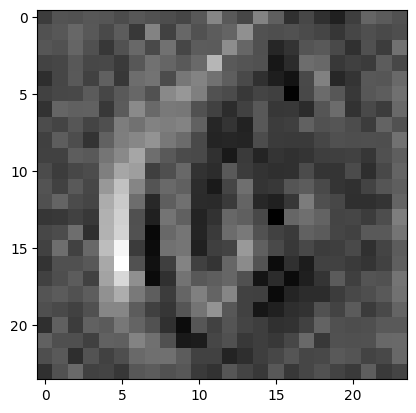

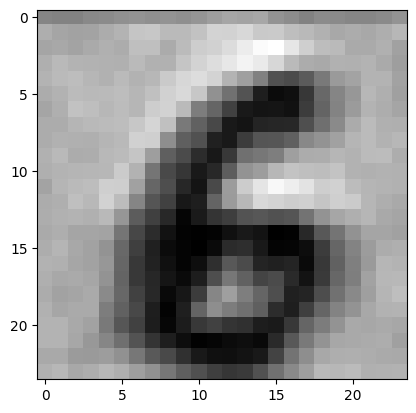

RELU2: torch.Size([3, 24, 24])


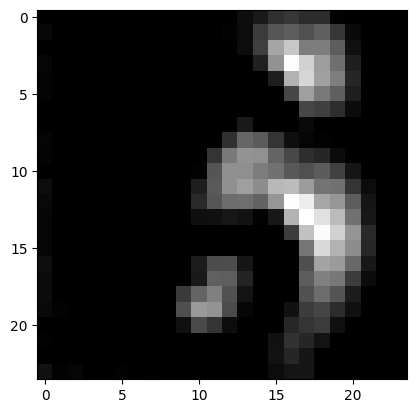

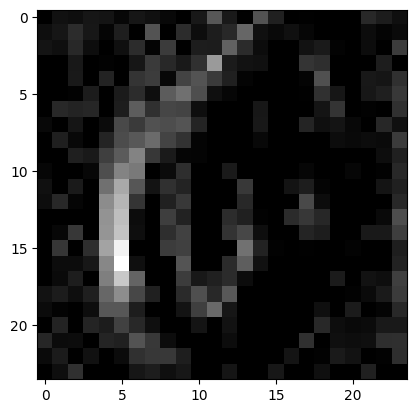

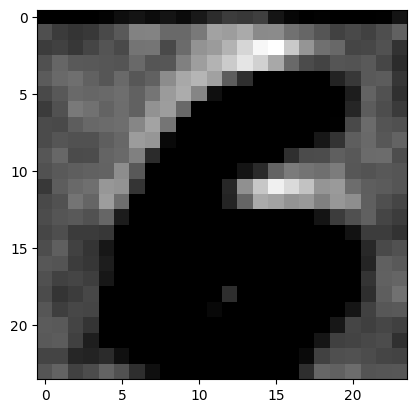

tensor([0.0000, 0.0000, 0.0000,  ..., 6.2828, 6.4263, 6.5400])


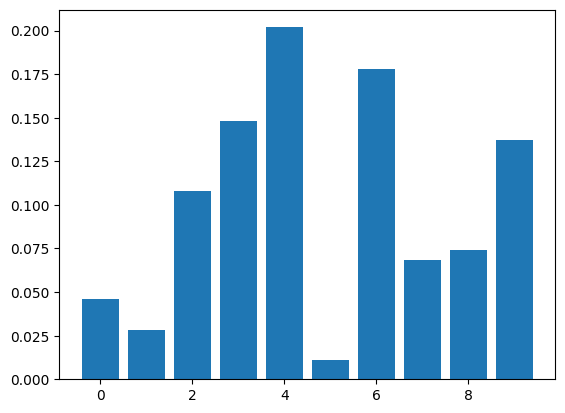

LABEL: tensor(6)
CONV1: torch.Size([3, 28, 28])


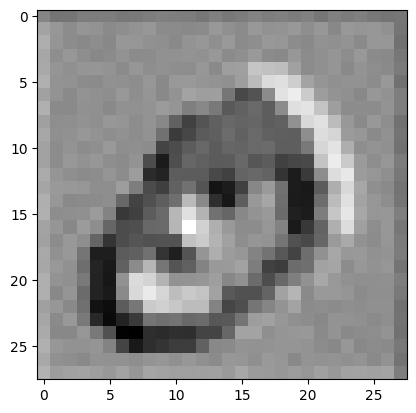

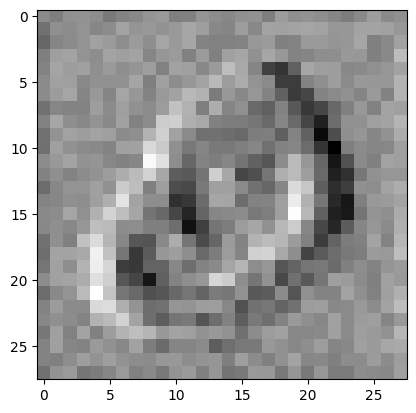

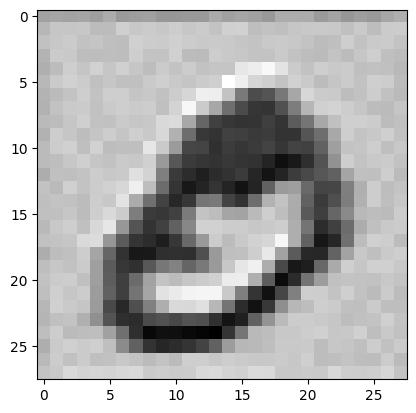

RELU1: torch.Size([3, 28, 28])


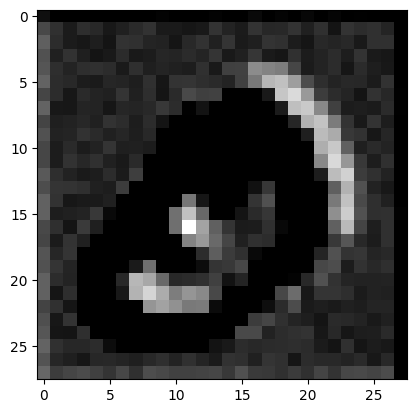

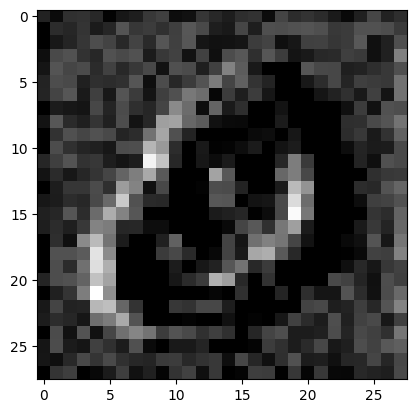

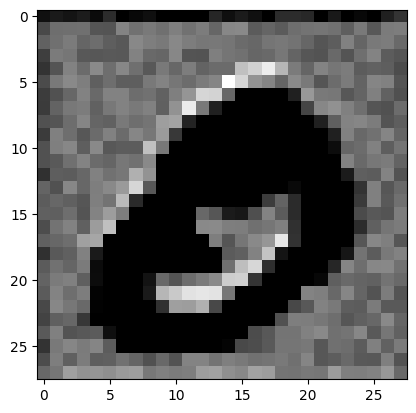

CONV2: torch.Size([3, 24, 24])


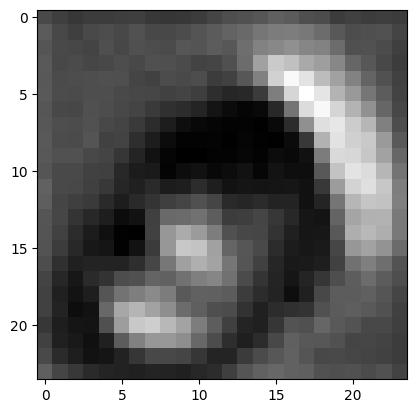

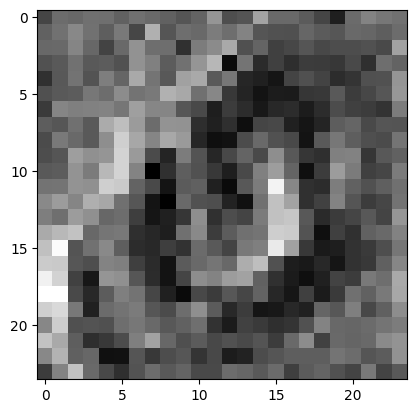

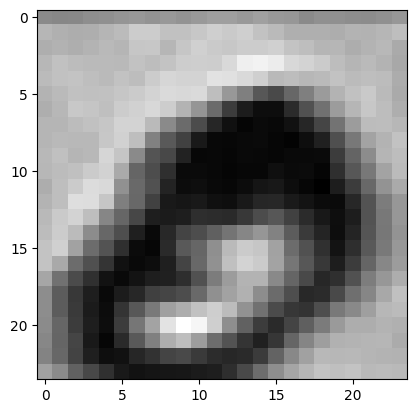

RELU2: torch.Size([3, 24, 24])


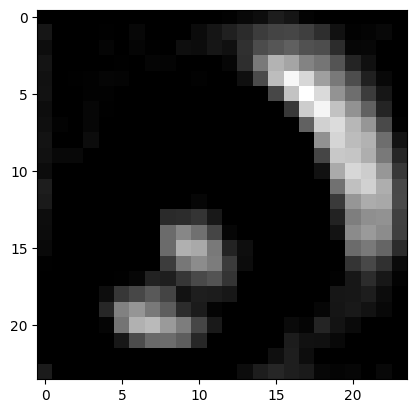

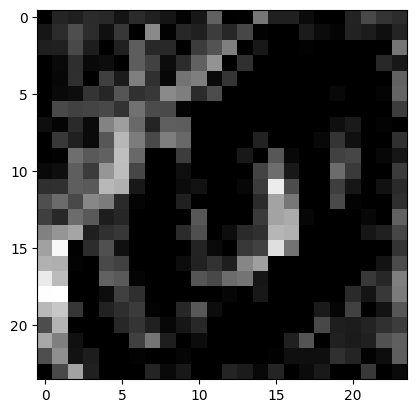

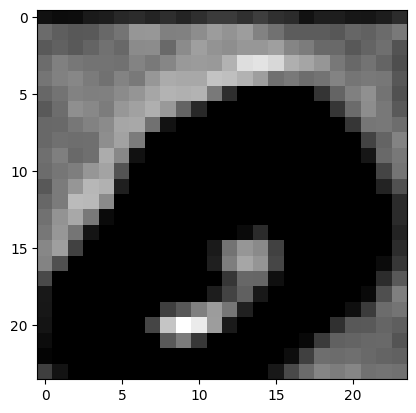

tensor([0.0000, 0.0000, 0.0000,  ..., 8.4583, 8.6908, 8.5292])


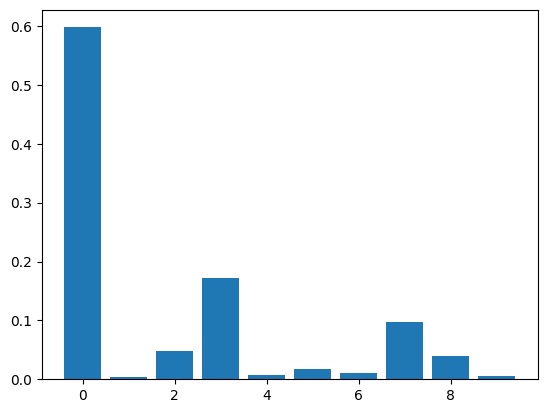

LABEL: tensor(0)
CONV1: torch.Size([3, 28, 28])


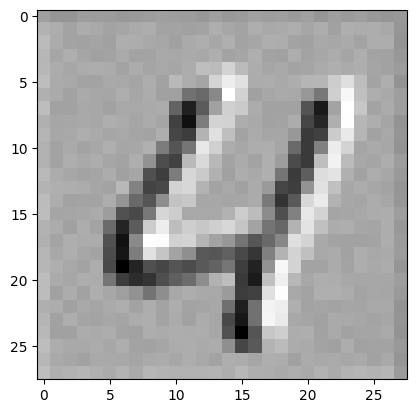

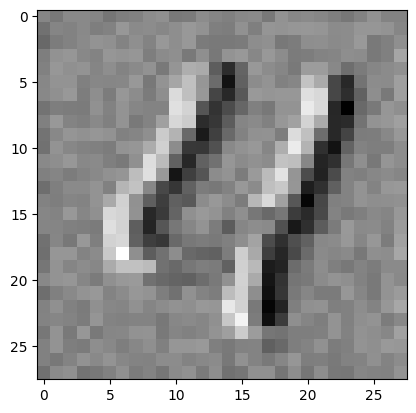

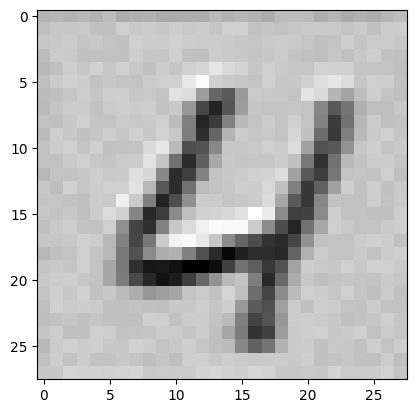

RELU1: torch.Size([3, 28, 28])


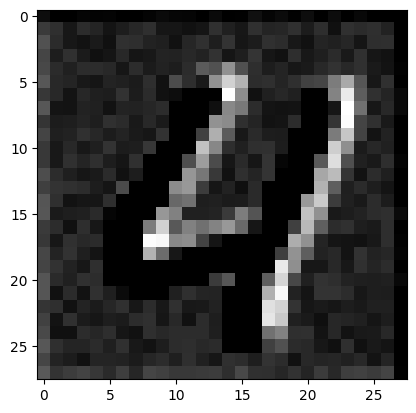

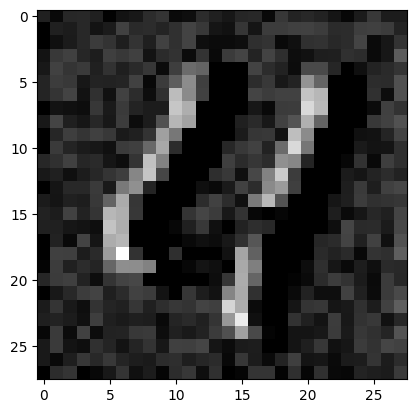

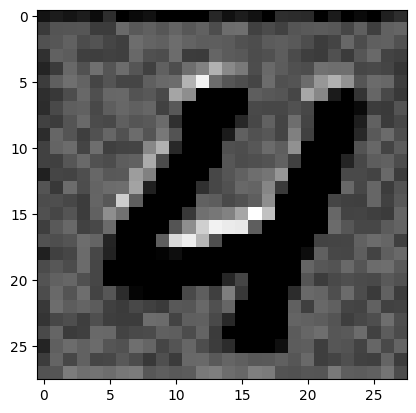

CONV2: torch.Size([3, 24, 24])


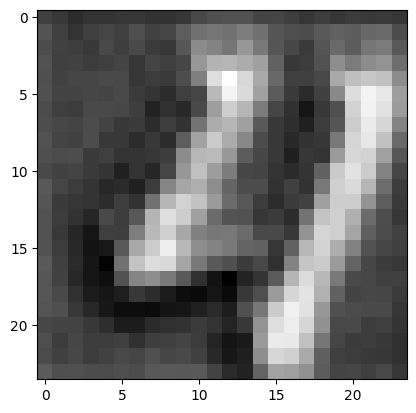

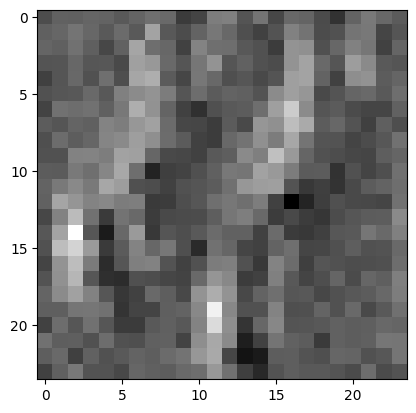

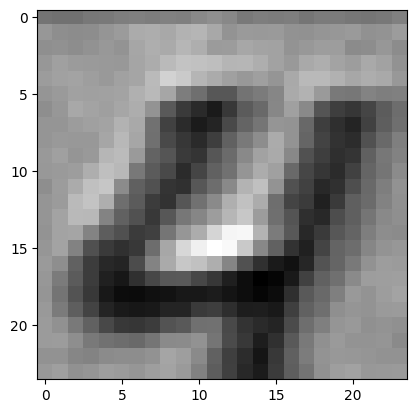

RELU2: torch.Size([3, 24, 24])


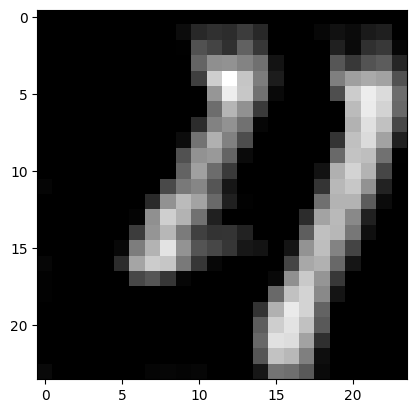

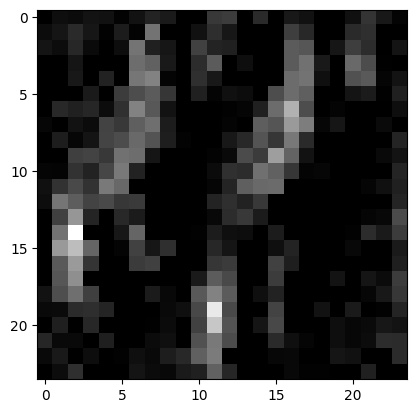

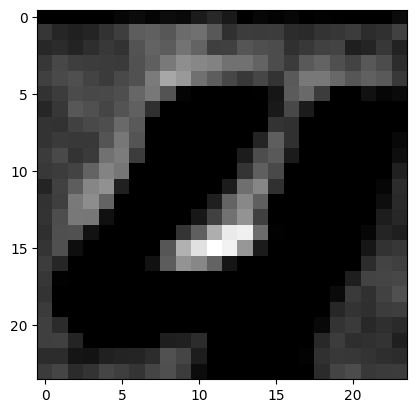

tensor([0.0000, 0.0000, 0.0000,  ..., 5.5696, 5.7084, 5.8617])


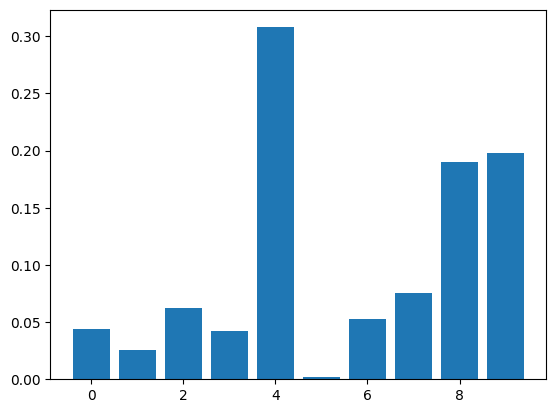

LABEL: tensor(4)
CONV1: torch.Size([3, 28, 28])


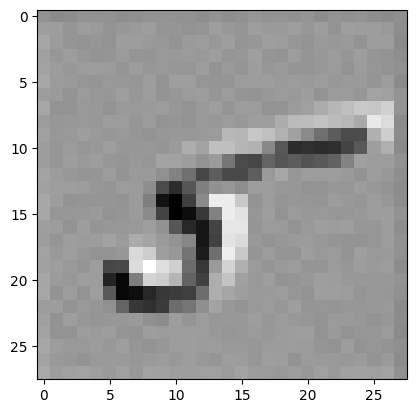

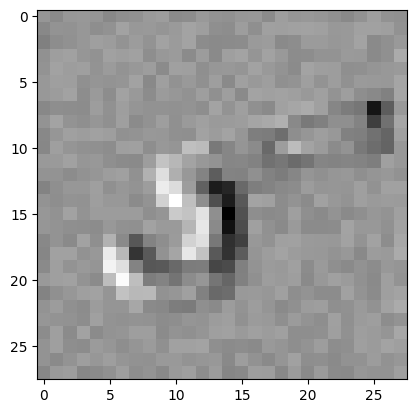

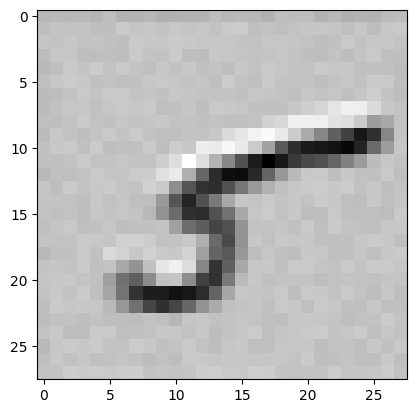

RELU1: torch.Size([3, 28, 28])


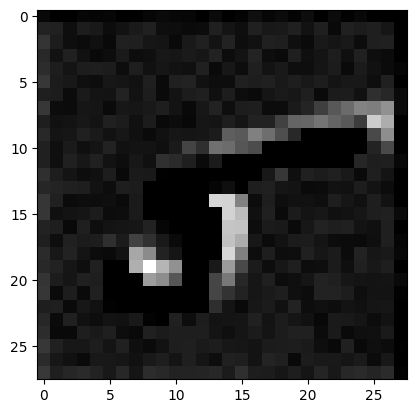

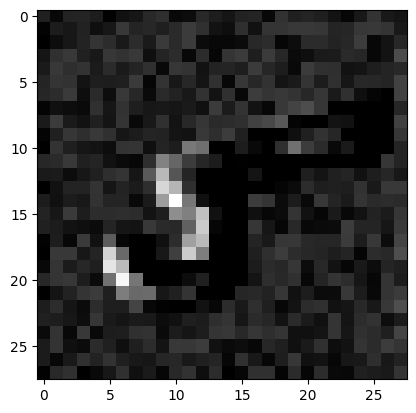

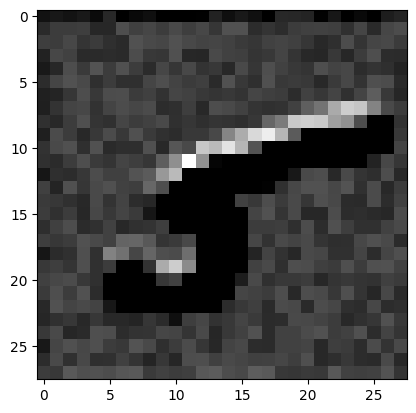

CONV2: torch.Size([3, 24, 24])


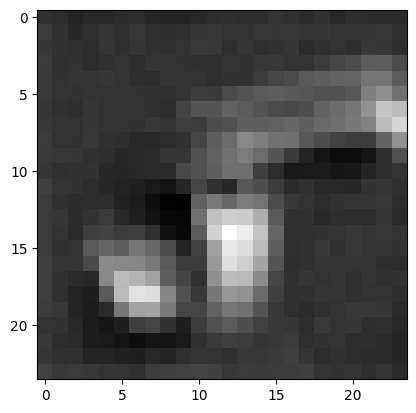

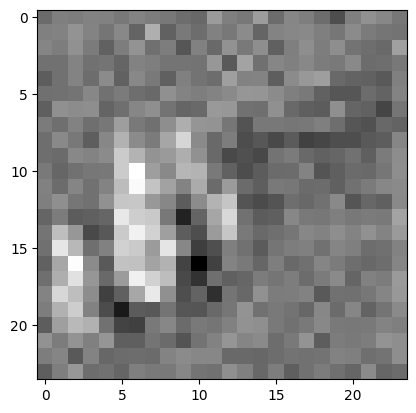

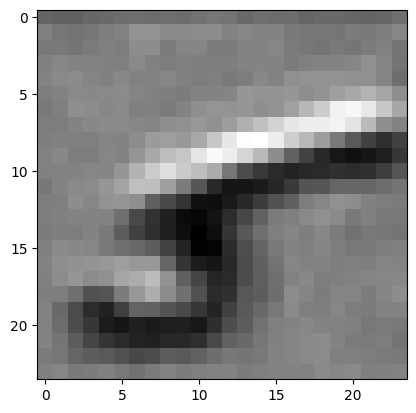

RELU2: torch.Size([3, 24, 24])


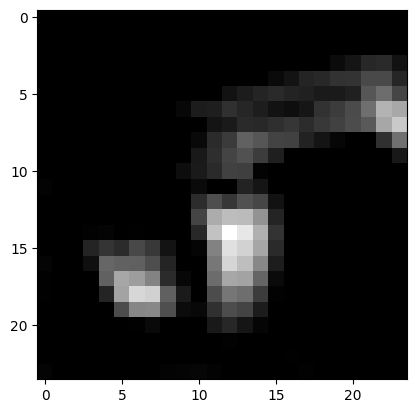

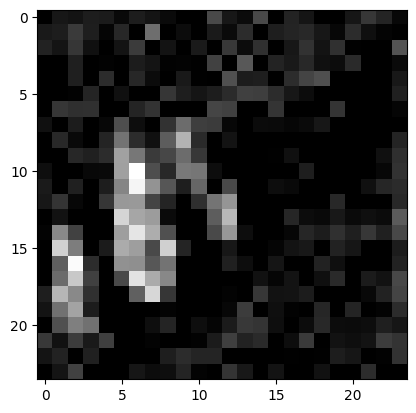

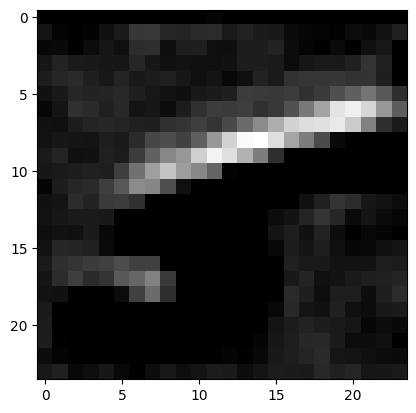

tensor([0.0000, 0.0000, 0.0000,  ..., 2.4405, 2.5472, 2.8763])


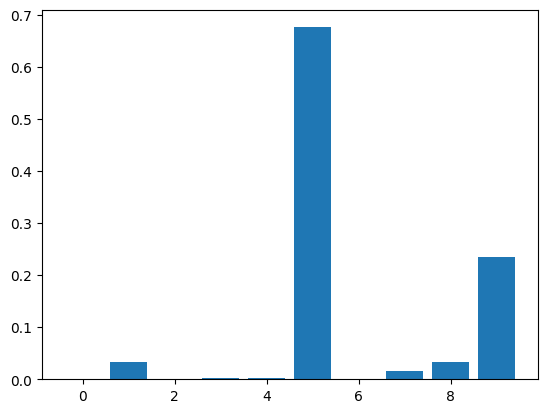

LABEL: tensor(5)
CONV1: torch.Size([3, 28, 28])


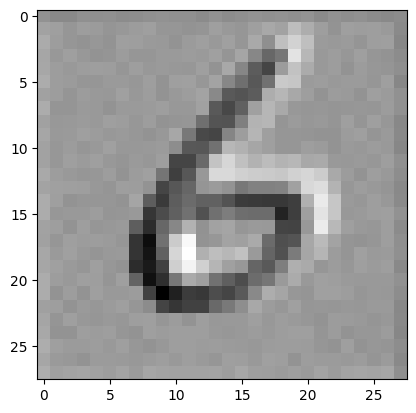

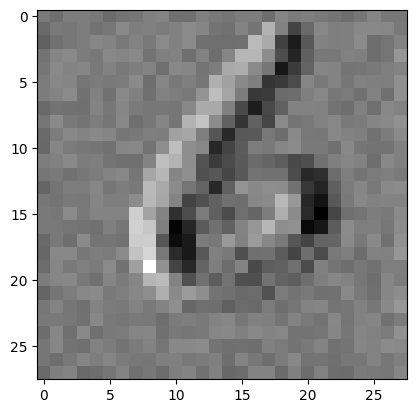

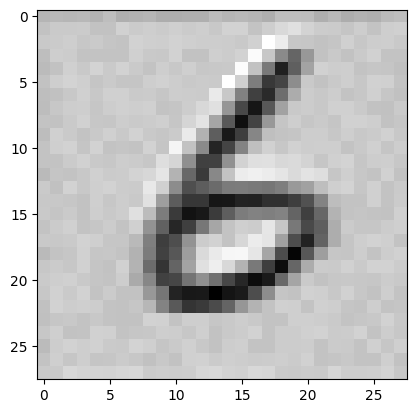

RELU1: torch.Size([3, 28, 28])


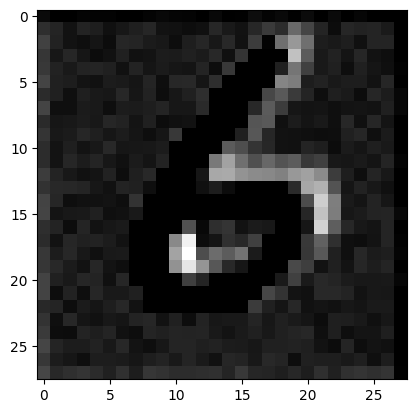

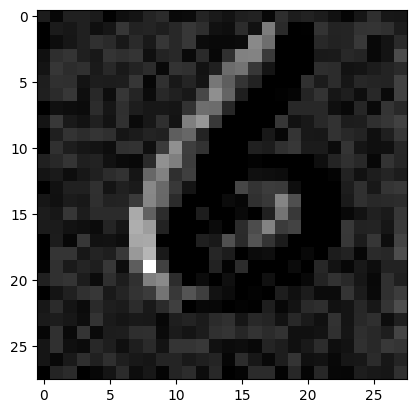

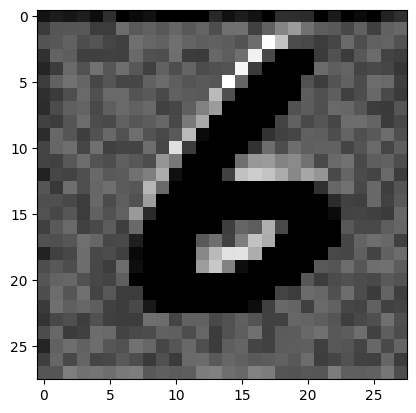

CONV2: torch.Size([3, 24, 24])


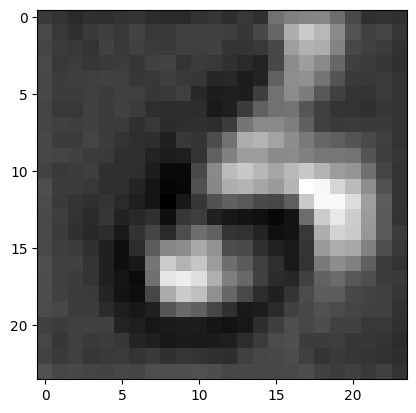

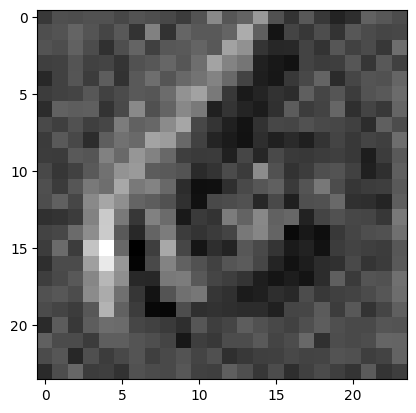

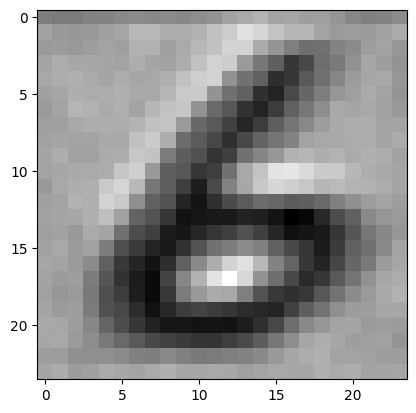

RELU2: torch.Size([3, 24, 24])


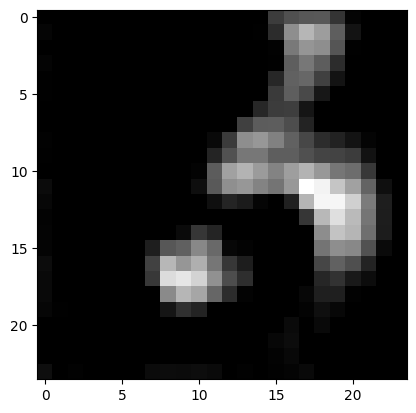

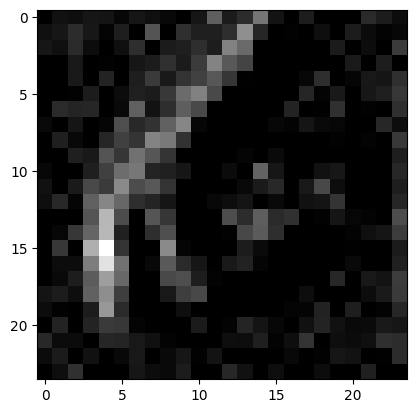

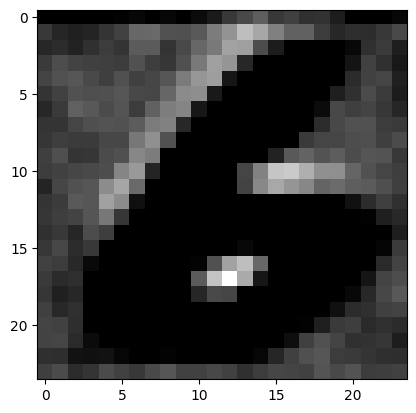

tensor([0.0000, 0.0000, 0.0000,  ..., 5.0204, 5.1553, 5.3249])


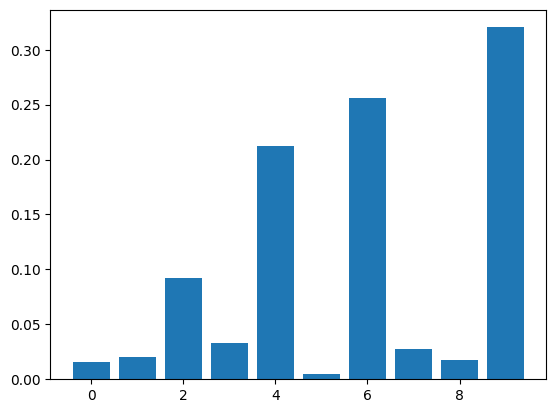

LABEL: tensor(6)
CONV1: torch.Size([3, 28, 28])


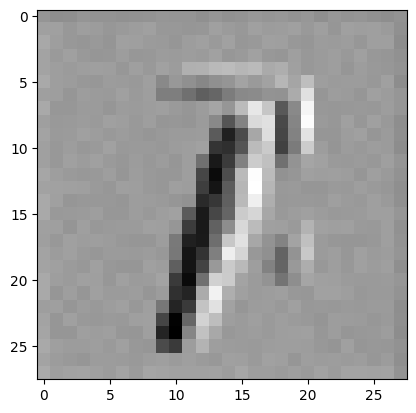

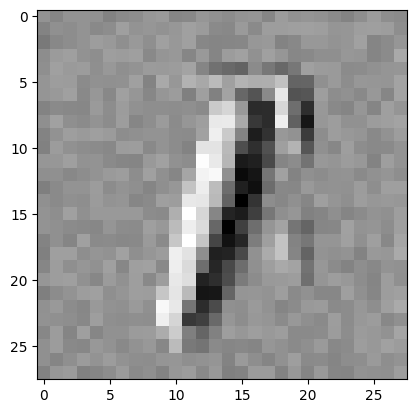

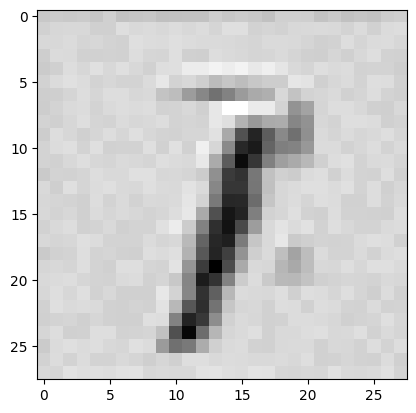

RELU1: torch.Size([3, 28, 28])


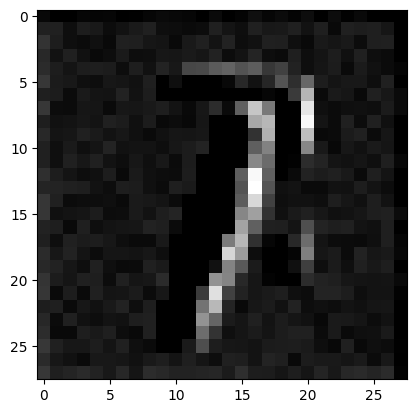

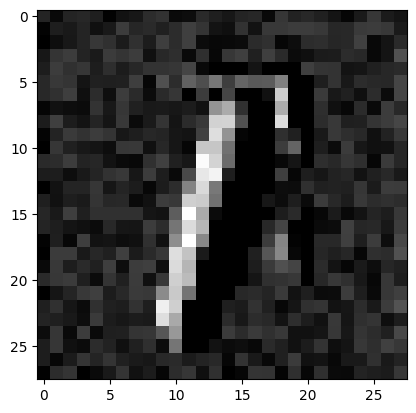

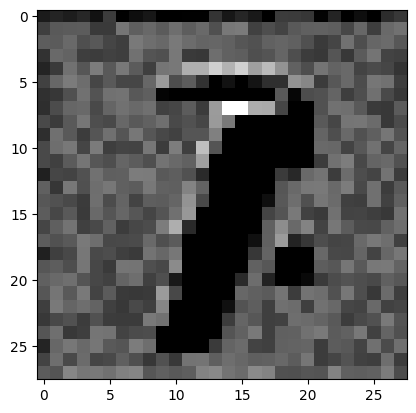

CONV2: torch.Size([3, 24, 24])


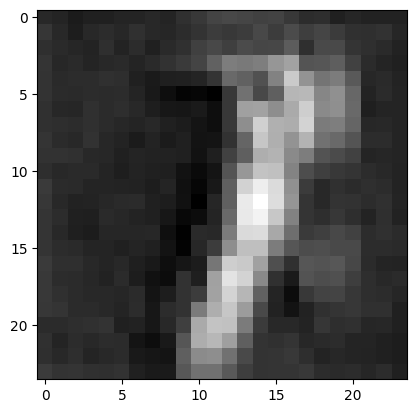

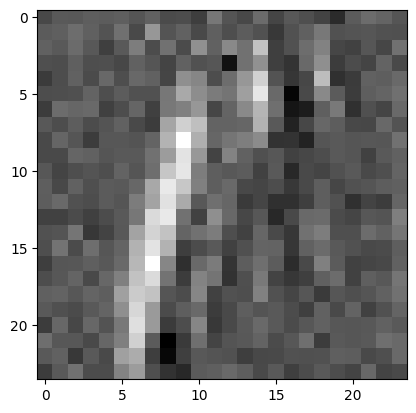

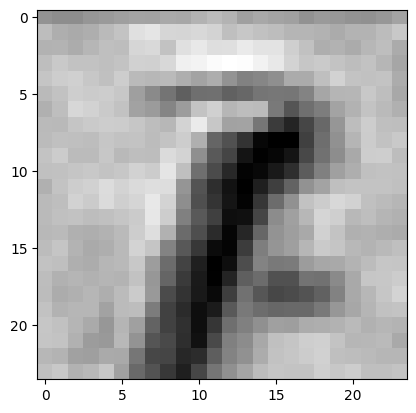

RELU2: torch.Size([3, 24, 24])


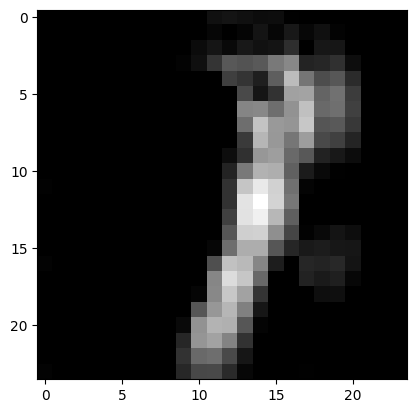

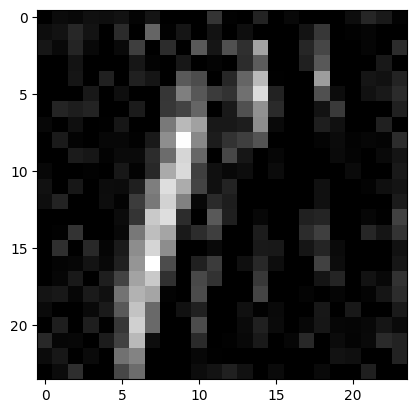

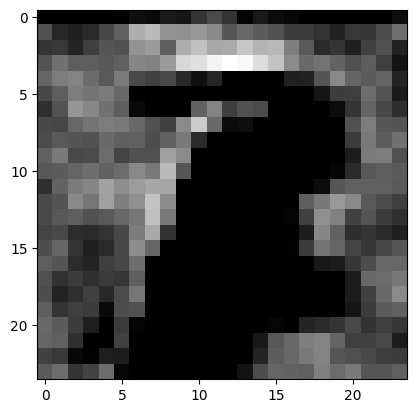

tensor([0.0000, 0.0000, 0.0000,  ..., 5.1399, 5.1179, 5.7231])


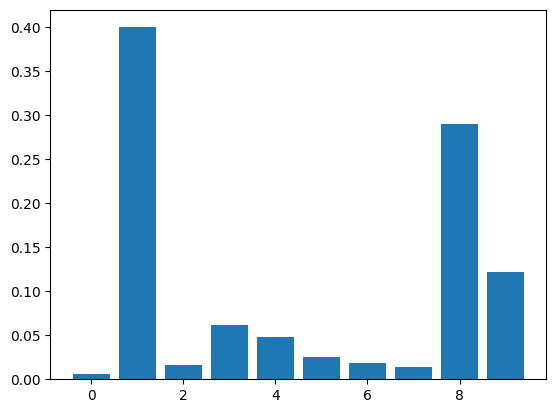

LABEL: tensor(1)
CONV1: torch.Size([3, 28, 28])


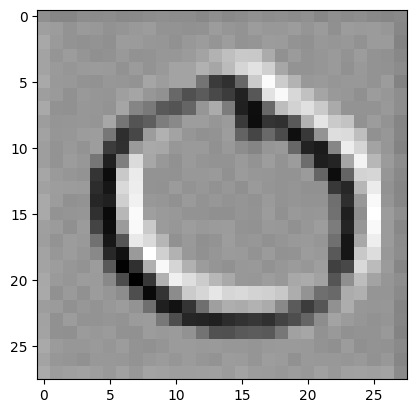

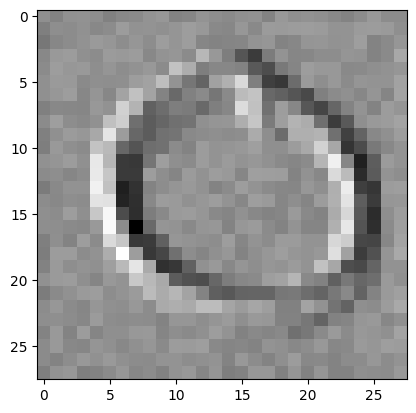

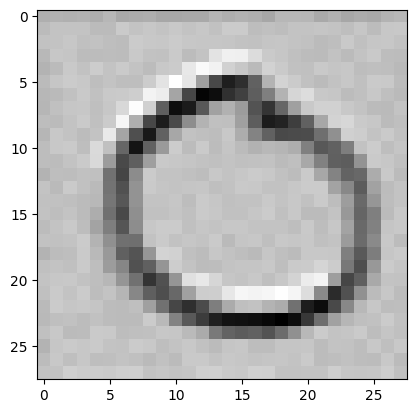

RELU1: torch.Size([3, 28, 28])


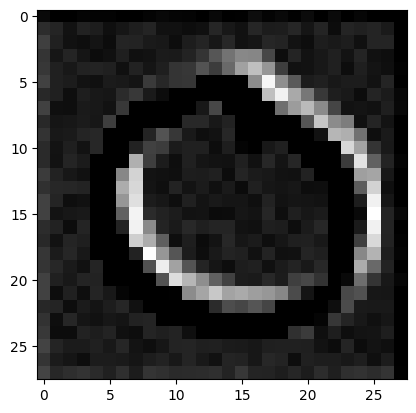

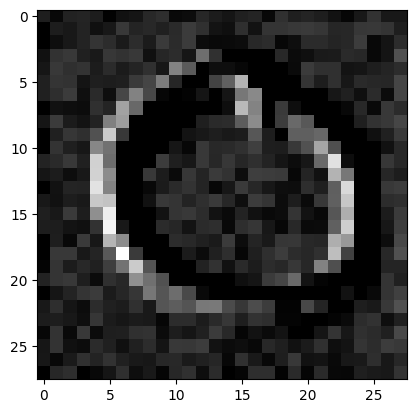

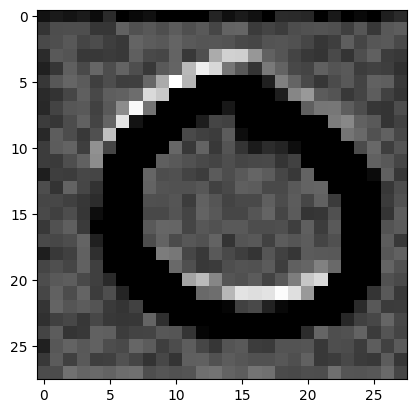

CONV2: torch.Size([3, 24, 24])


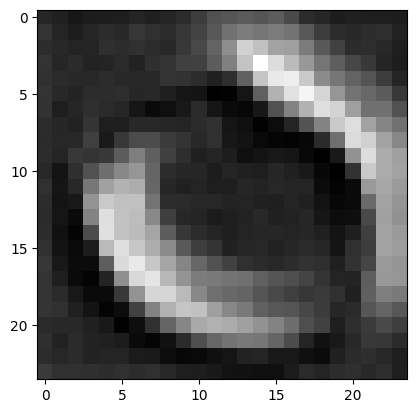

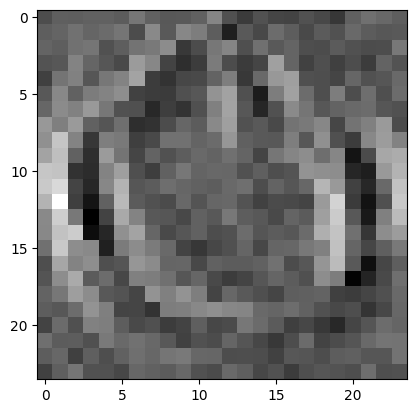

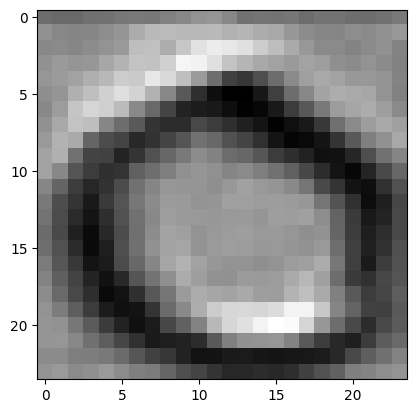

RELU2: torch.Size([3, 24, 24])


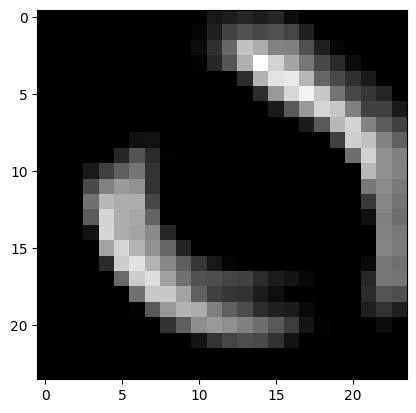

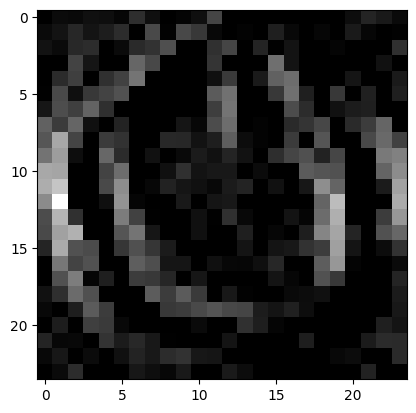

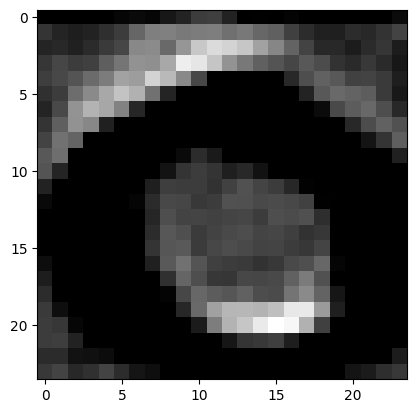

tensor([0.0000, 0.0000, 0.0000,  ..., 2.3878, 4.0390, 4.9615])


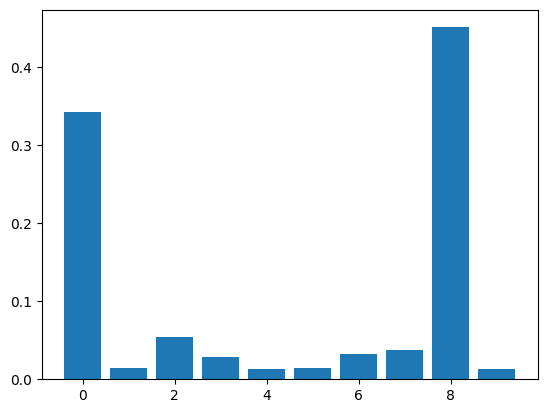

LABEL: tensor(0)
CONV1: torch.Size([3, 28, 28])


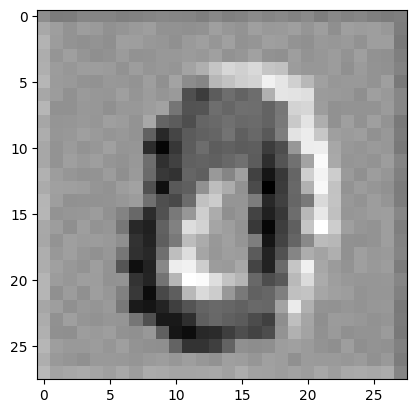

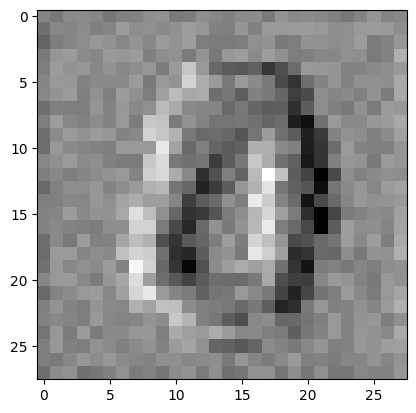

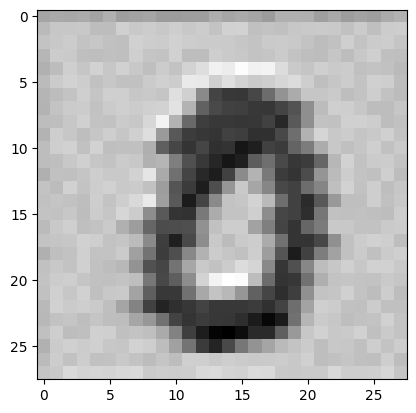

RELU1: torch.Size([3, 28, 28])


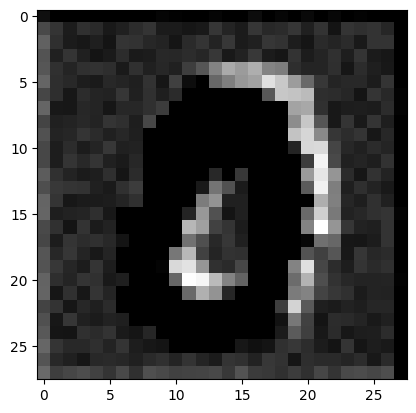

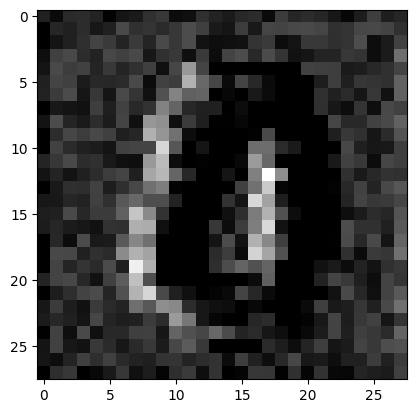

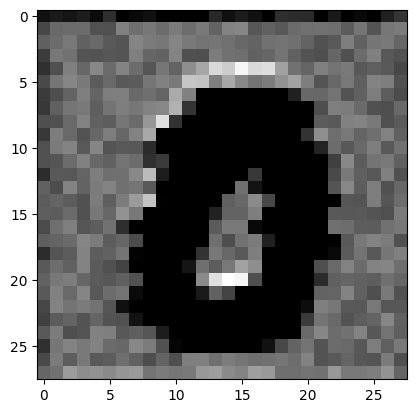

CONV2: torch.Size([3, 24, 24])


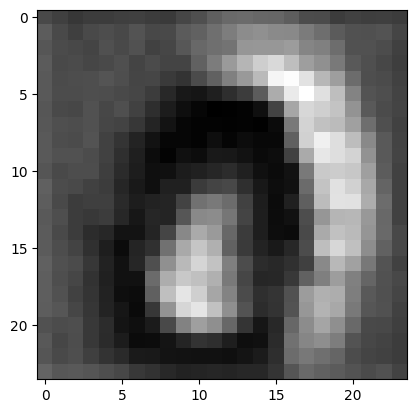

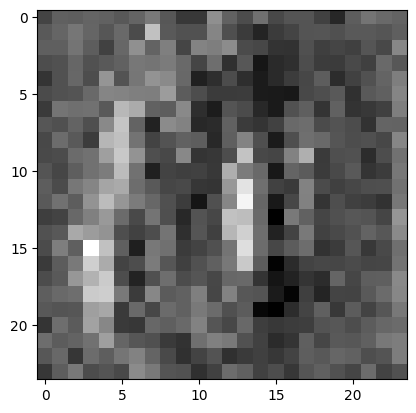

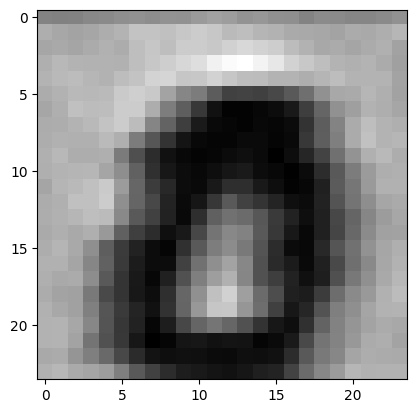

RELU2: torch.Size([3, 24, 24])


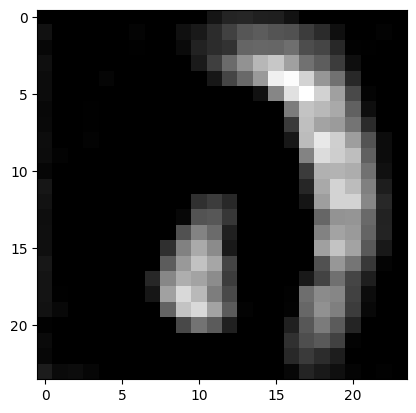

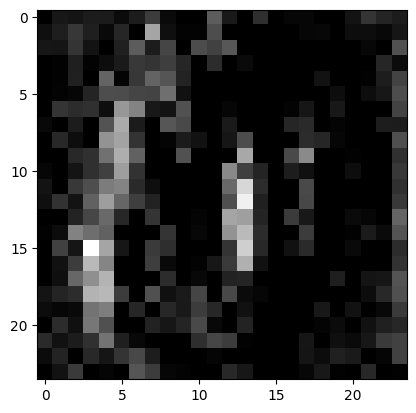

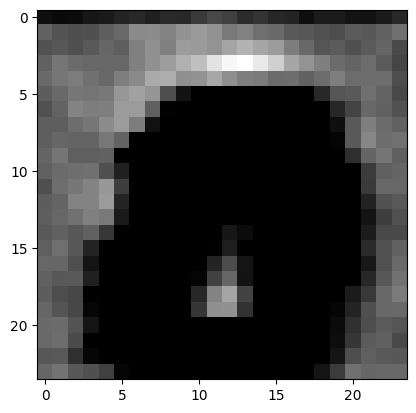

tensor([0.0000, 0.0000, 0.0000,  ..., 8.6282, 8.8264, 8.7507])


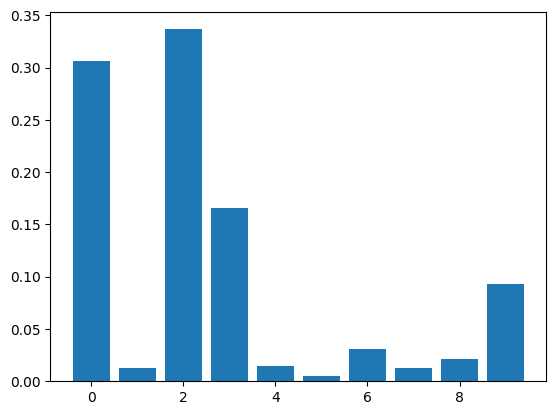

LABEL: tensor(0)


In [34]:
if SHOW:
    for i in range(10):
        result = model.forward_show(train_batch[0][i])
        plt.bar([0,1,2,3,4,5,6,7,8,9], result)
        plt.show()
        print("LABEL:", train_batch[1][i])